## Excavator Detection: Object Detection (V2)

Dataset Source: https://huggingface.co/datasets/keremberke/excavator-detector

#### Install Necessary Libraries

In [1]:
%pip install transformers evaluate datasets tensorboard albumentations timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 756.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━

#### Import Necessary Libraries

In [2]:
import os, sys, json

import numpy as np
import matplotlib.pyplot as plt

import albumentations

from PIL import ImageDraw
import PIL.Image
from IPython.display import Image, display

from tqdm import tqdm
import torchvision
import evaluate

import transformers
from transformers import AutoModelForObjectDetection, AutoImageProcessor
from transformers import TrainingArguments, Trainer

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

import datasets
from datasets import load_dataset

#### Access to HuggingFace Hub

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

#### Display Versions of Relevant Libraries

In [4]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Torch Vision:".rjust(15), torchvision.__version__)

        Python: 3.9.16
         NumPy: 1.22.4
  Transformers: 4.27.1
         Torch: 1.13.1+cu116
  Torch Vision: 0.14.1+cu116


#### Ingest Data

In [5]:
dataset = load_dataset("keremberke/excavator-detector", "full")

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset excavator-detector downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___excavator-detector/full/1.0.0/09d67ac57779ec71c5ef743aaffb2ca025f7f0b44547bf6b7f7014df950cef00. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2245
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 267
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 144
    })
})

##### Visualize Example

{0: 'excavators', 1: 'dump truck', 2: 'wheel loader'}
{'excavators': 0, 'dump truck': 1, 'wheel loader': 2}


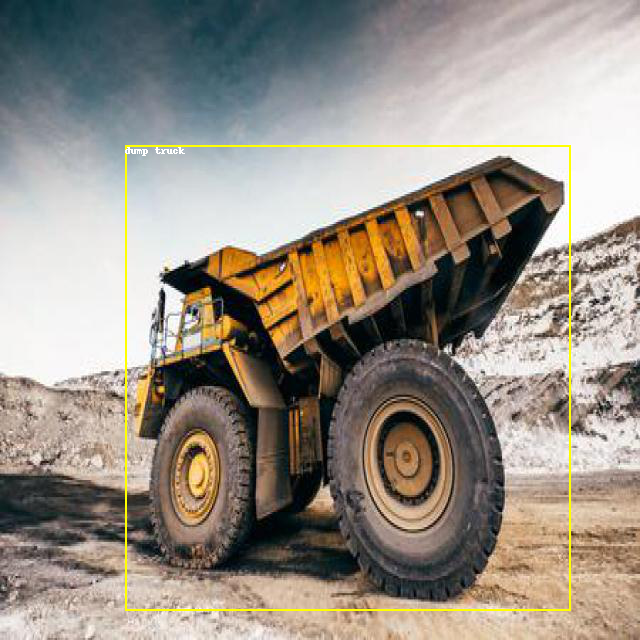

In [6]:
image = dataset['train'][12]['image']

annotations = dataset['train'][12]['objects']

draw = ImageDraw.Draw(image)

categories = dataset["train"].features["objects"].feature["category"].names

id2label = {k: v for k, v in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

print(id2label)
print(label2id)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="yellow", width=2)
    draw.text((x, y), id2label[class_idx], fill="white")
    
image

#### Basic Values/Constants

In [7]:
MODEL_CKPT = "facebook/detr-resnet-50"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Excavator_Detection_v2"

LEARNING_RATE = 1e-5
NUM_OF_EPOCHS = 50

WEIGHT_DECAY = 1e-4
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
BATCH_SIZE = 8

##### Preprocess Data

In [8]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

#### Define Data Augmentations to Apply to Dataset

In [9]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0)
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"])
)

#### Reformat Annotations for Image Processor Expectations

In [10]:
def formatted_anns(image_id, category, area, bbox):
    annotations= []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)
    return annotations

#### Combine Image & Data Augmentations into Single Function

In [11]:
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

#### Apply Image & Data Augmentation Function to Training Dataset

In [12]:
dataset["train"] = dataset["train"].with_transform(transform_aug_ann)
dataset["train"][12]

/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


{'pixel_values': tensor([[[ 0.1768,  0.1597,  0.1426,  ..., -1.5357, -1.5357, -1.5357],
          [ 0.1768,  0.1597,  0.1426,  ..., -1.5357, -1.5357, -1.5357],
          [ 0.1768,  0.1768,  0.1597,  ..., -1.5185, -1.5185, -1.5185],
          ...,
          [-0.5938, -0.6965, -0.8507,  ...,  0.7762,  0.8104,  0.8447],
          [-0.5596, -0.6794, -0.8849,  ...,  0.7077,  0.7419,  0.7762],
          [-0.5424, -0.6794, -0.9020,  ...,  0.6563,  0.6906,  0.7248]],
 
         [[ 0.3102,  0.2927,  0.2752,  ..., -1.6155, -1.6331, -1.6331],
          [ 0.3102,  0.2927,  0.2752,  ..., -1.6155, -1.6331, -1.6331],
          [ 0.3102,  0.3102,  0.2927,  ..., -1.6155, -1.6155, -1.6155],
          ...,
          [-0.1450, -0.2500, -0.4076,  ...,  0.9580,  0.9930,  1.0280],
          [-0.1099, -0.2500, -0.4426,  ...,  0.8880,  0.9230,  0.9580],
          [-0.0924, -0.2500, -0.4776,  ...,  0.8354,  0.8704,  0.9055]],
 
         [[ 0.7402,  0.7228,  0.7054,  ..., -1.8044, -1.8044, -1.8044],
          [ 

#### Define Data Collator

In [13]:
def collate_function(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

#### Instantiate Model

In [14]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_first_step=True,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    remove_unused_columns=False,
    fp16=True,
    push_to_hub=True
)

##### Instantiate Trainer

In [16]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_function,
    train_dataset=dataset['train'],
    tokenizer=image_processor,
)

Cloning https://huggingface.co/DunnBC22/detr-resnet-50-Excavator_Detection_v2 into local empty directory.


#### Train Model

In [ ]:
training_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:970: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(


Step,Training Loss
1,2.445200
281,1.245300
562,0.957800
843,0.876800
1124,0.813400
1405,0.777400
1686,0.730500
1967,0.699900
2248,0.661200
2529,0.628000


/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:970: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:970: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/detr/image_processing_detr.py:886: 

#### Push Model to Hub (My Profile!!!!)

In [ ]:
trainer.push_to_hub()

#### Function to Format Dataset for Evaluation 

In [ ]:
def eval_formatted_anns(img_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": img_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations

#### Save Annotations File 

In [ ]:
def save_annotation_file_images(input):
    output_json = {}
    path_output = f"{os.getcwd()}/excavators/"

    if not os.path.exists(path_output):
        os.makedirs(path_output)

    path_anno = os.path.join(path_output, "excavators_ann.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in input:
        ann = eval_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(input["image"], input["image_id"]):
        path_img = os.path.join(path_output, f"{img_id}.png")
        im.save(path_img)

    return path_output, path_anno

#### Define CocoDetection Dataset Class

In [ ]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image & target in coco format
        img, target = super(CocoDetection, self).__getitem__(idx)

        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

path_output, path_anno = save_annotation_file_images(input["test"])
test_ds_coco_format = CocoDetection(path_output, im_processor, path_anno)

#### Calculate Metrics

In [ ]:
model = AutoModelForObjectDetection.from_pretrained(MODEL_NAME)
module = evaluate.load("ybelkada/cocoevaluate", 
                       coco=test_ds_coco_format.coco)

val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, 
    batch_size=8, 
    shuffle=False, 
    num_workers=4, 
    collate_fn=collate_function
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized & normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack(
            [target["orig_size"] for target in labels]
            , dim=0)
        
        # this converts outputs to COCO
        results = im_processor.post_process(outputs, 
                                            orig_target_sizes)  

        module.add(prediction=results, reference=labels)
        del batch

#### Viola!!!

In [ ]:
results = module.compute()

### Notes & Other Takeaways

****
- I wish this project would not have timed out on Google Colab. Comparing the loss curve in this project to the previous version, it had great promise.

****

### Citations
- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2005-12872, author = {Nicolas Carion and Francisco Massa and Gabriel Synnaeve and Nicolas Usunier and Alexander Kirillov and Sergey Zagoruyko}, title = {End-to-End Object Detection with Transformers}, journal = {CoRR}, volume = {abs/2005.12872}, year = {2020}, url = {https://arxiv.org/abs/2005.12872%7D, archivePrefix = {arXiv}, eprint = {2005.12872}, timestamp = {Thu, 28 May 2020 17:38:09 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2005-12872.bib%7D, bibsource = {dblp computer science bibliography, https://dblp.org%7D}

- Metric
    > https://huggingface.co/spaces/ybelkada/cocoevaluate